# A workflow to analyze any given disease-associated repeat locus

## Authors
- Anita Szabo, UCL
- Christina Zarouchlioti, UCL
- Egor Dolzhenko, PacBio
- Alice Davidson, UCL

## Introduction

Expansion of repeatitive elements across the human genome are now known to cause over 40 human diseases. To better understand the complex molecular mechanisms driving this group of genetic diseases, it is now widely appreciated that in-depth interrogation of the causative loci is a necessity. Features such as repeat length, stability, sequence composition, as well as the epigenetic modifications, can all influence disease onset, severity, expressitivity and penetrance.

This analysis workflow enables users to interrogate PacBio HiFi datasets to gain insights into any given disease-associated tandem repeat locus. TRGT output files (https://github.com/PacificBiosciences/trgt) are used as the input data for this workflow. Here, we are using a non-coding **triplet repeat expansion in the TCF4 gene** (termed CTG18.1) associated with a common age-related eye disease (OMIM:#613267) as an exemplar locus of interest to showcase the utility of this pipeline.

## Part I: Analysing human pangenome Pacbio HiFi data

In this example, we will be using data from 100 individuals recruited to the Human Pangenome Reference Consortium generated at PacBio using HG002 libraries created at Washington University. The data set has a large, tight size fraction targeting 20kb. (Egor please edit as appropriate)

Import the necessary libraries.

In [8]:
import os
import json
import pysam
import gzip
import itertools
import numpy as np
from collections import namedtuple
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
plt.rcParams['figure.figsize'] = [16.5, 5]
plt.rcParams['font.size'] = 10

Define paths and workflow parameters

In [2]:
allele_db_path = "../101-allele-db/output/allele.db.gz"
motif_len = 3

In [3]:
Rec = namedtuple("Rec", "sample allele reads")

In [4]:
allele_db = []
with gzip.open(allele_db_path, "rb") as file:
    for line in file:
        line = line.decode("utf8")
        trid, sample, allele, reads, counts = line.split()
        reads = reads.split(",")
        counts = [int(c) for c in counts.split(",")]
        reads = [(r, c) for r, c in zip(reads, counts)]
        allele_db.append(Rec(sample, allele, reads))

We next plot a histogram of allele lengths. It shows that although most TCF4 alleles are short, there is one allele spanning nearly three Kbps. We next visualize lengths of repeats in samples with 20 longest alleles, showing that some alleles span over 100 CAG motifs (300 bps) and that most of these longer alleles are associated with a relatively wide size range which is consistent with presence of significant somatic mosaicism.

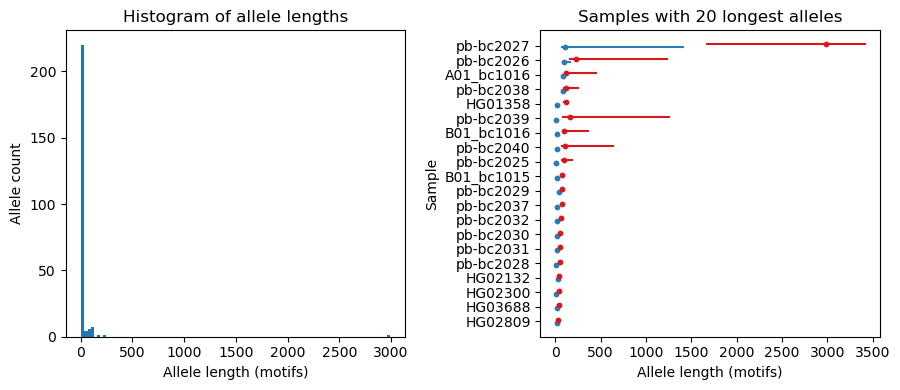

In [5]:
def get_lens_and_ranges(allele_db):
    lens_and_ranges = []
    for sample, recs in itertools.groupby(allele_db, key=lambda rec: rec.sample):
        recs = list(recs)
        allele_lens = [int(round(len(rec.allele) / motif_len)) for rec in recs]
        read_lens = [[len(r) for r, c in rec.reads] for rec in recs]
        read_ranges = [(int(round(min(lens) / motif_len)), 
                        int(round(max(lens) / motif_len))) for lens in read_lens]
        lens_and_ranges.append((sample, allele_lens, read_ranges))
    return lens_and_ranges


lens_and_ranges = get_lens_and_ranges(allele_db)
lens_and_ranges.sort(key=lambda rec: rec[2][1])
lens_and_ranges = lens_and_ranges[-20:]

samples = [s for s, _, _ in lens_and_ranges]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 4))

al_lens = [len(rec.allele) / motif_len for rec in allele_db]
ax1.hist(al_lens, bins=100)
ax1.set_xlabel("Allele length (motifs)")
ax1.set_ylabel("Allele count")
ax1.set_title("Histogram of allele lengths")

for sample_index, (sample, al_lens, al_ranges) in enumerate(lens_and_ranges):
    colors = ["#2c7bb6", "#d7191c"]
    offset = [-0.1, 0.1]
    for al_index in range(len(al_lens)):
        y = [sample_index + offset[al_index]]
        xs = [al_ranges[al_index][0], al_lens[al_index], al_ranges[al_index][1]]
        ax2.plot([xs[0], xs[2]], [y, y], color=colors[al_index], marker="none", linewidth=1.5)
        ax2.scatter([xs[1]], [y], color=colors[al_index], s=10.0)

    ax2.yaxis.set_ticks(range(0, len(samples)))
    ax2.yaxis.set_ticklabels(samples)
    ax2.set_xlabel("Allele length (motifs)")
    ax2.set_ylabel("Sample")
    ax2.set_title("Samples with 20 longest alleles")

plt.tight_layout()

## Part II: Read-level analysis of TCF4 long alleles

In [6]:
long_alleles = [rec for rec in allele_db if len(rec.allele) / motif_len >= 100]

In [35]:
len(long_alleles)

9

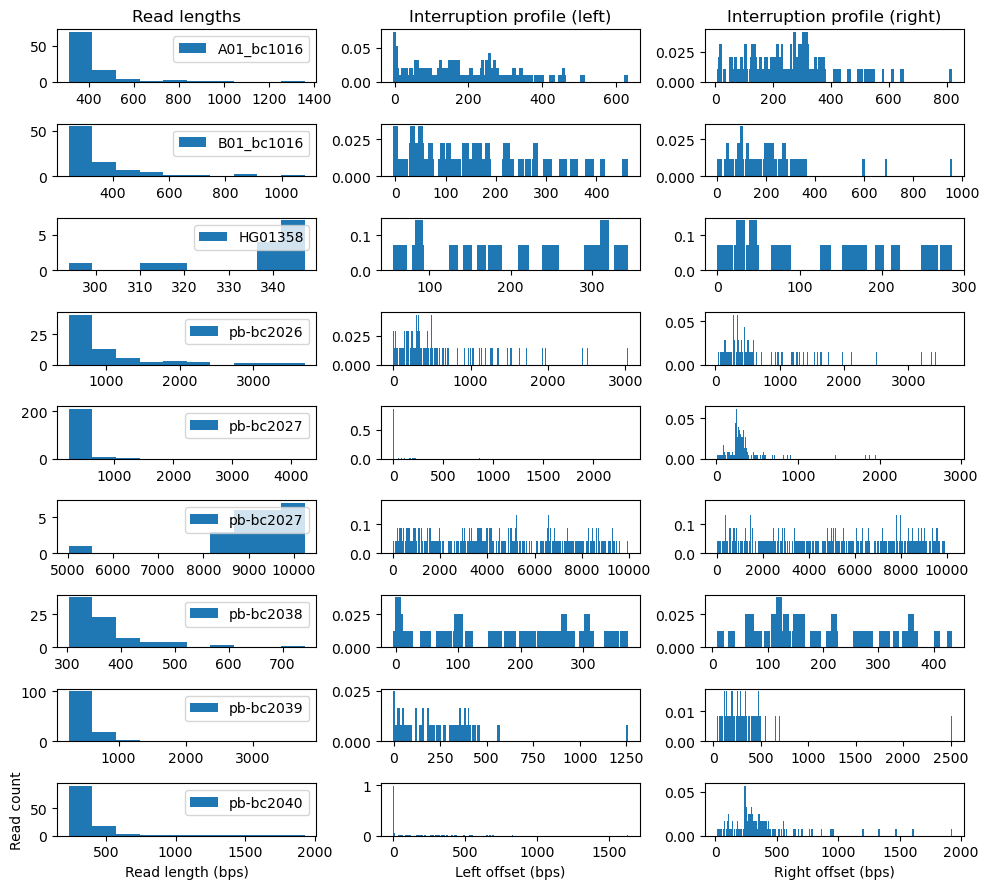

In [33]:
from collections import Counter


def plot_bars(values, norm, ax):
    values = list(Counter(values).items())
    xs = [p for p, c in values]
    ys = [c / norm for p, c in values]
    ax.bar(xs, ys, width=10.0)


def get_mm_profile(motif, seq):
    mms = []
    pos = 0
    while pos + len(motif) <= len(seq):
        putative_motif = seq[pos:pos + len(motif)]
        if putative_motif == motif:
            pos += len(motif)
        else:
            mms.append(pos)
            pos += 1
    
    return mms


def plot_sample_info(sample, reads, axs):
    read_lens = []
    fwd_mms, rev_mms = [], []

    num_reads = 0
    for read, count in reads:
        read_lens.extend([len(read)] * count)
        mms = get_mm_profile("CAG", read)
        fwd_mms.extend(mms * count)
        rev_mms.extend([len(read) - mm for mm in mms] * count)
        num_reads += count

    axs[0].hist(read_lens, label=sample)
    axs[0].legend(loc="upper right")
    plot_bars(fwd_mms, num_reads, axs[1])
    plot_bars(rev_mms, num_reads, axs[2])
    

num_alleles = len(long_alleles)
fig, axs = plt.subplots(ncols=3, nrows=num_alleles, figsize=(10, num_alleles))

for allele, ax_row in zip(long_alleles, axs):
    plot_sample_info(allele.sample, allele.reads, ax_row)

axs[0][0].set_title("Read lengths")
axs[0][1].set_title("Interruption profile (left)")
axs[0][2].set_title("Interruption profile (right)")

axs[-1][0].set_xlabel("Read length (bps)")
axs[-1][0].set_ylabel("Read count")

axs[-1][1].set_xlabel("Left offset (bps)")
axs[-1][2].set_xlabel("Right offset (bps)")
plt.tight_layout();

Further libraries are imported for the steps below.

In [12]:
import subprocess
from IPython.display import Image

The 'trvz' linux-based tool is used to visualise the reads. (It can be downloaded from https://github.com/PacificBiosciences/trgt/releases) 
We have to specify the path to this binary executable file, reference genome, repeat catalog and the directory containing the bam, vcf output of 'trgt'. We also have to specify a lcoation where the generated images can be saved.

In [28]:
def plot_trvz(sample, trid):
    binary = "/home/edolzhenko/flash/2023/Q4/trgt/trvz/target/release/trvz"
    genome = "/home/edolzhenko/common/hg38/hg38.fa"
    catalog = "../100-trgt/TCF4.bed"
    vcf = f"../100-trgt/output/{sample}.vcf.gz"
    bam = f"../100-trgt/output/{sample}.bam"
    name = f"{sample}-{trid}"
    subprocess.run([binary,
                    "--genome", genome, 
                    "--repeats", catalog,
                    "--vcf", vcf,
                    "--spanning-reads", bam,
                    "--repeat-id", trid,
                    "--image", f"output/{name}.allele.png",
                    "--plot-type", "allele"])
    
    subprocess.run([binary,
                    "--genome", genome,
                    "--repeats", catalog,
                    "--vcf", vcf,
                    "--spanning-reads", bam,
                    "--repeat-id", trid,
                    "--image", f"output/{name}.waterfall.png",
                    "--plot-type", "waterfall"])


In [29]:
target_sample = "pb-bc2040"
target_repeat = "TCF4"

plot_trvz(target_sample, target_repeat)

2024-01-14 17:49:53 [WARN] - No match for 'monospace' font-family.
2024-01-14 17:49:53 [WARN] - No match for 'monospace' font-family.
2024-01-14 17:49:53 [WARN] - No match for 'monospace' font-family.
2024-01-14 17:49:53 [WARN] - No match for 'monospace' font-family.
2024-01-14 17:49:53 [WARN] - No match for 'monospace' font-family.
2024-01-14 17:49:53 [WARN] - No match for 'monospace' font-family.
2024-01-14 17:49:53 [WARN] - No match for 'monospace' font-family.
2024-01-14 17:49:53 [WARN] - No match for 'monospace' font-family.
2024-01-14 17:49:53 [WARN] - No match for 'monospace' font-family.
2024-01-14 17:49:53 [WARN] - No match for 'monospace' font-family.
2024-01-14 17:49:53 [WARN] - No match for 'monospace' font-family.
2024-01-14 17:49:53 [WARN] - No match for 'monospace' font-family.
2024-01-14 17:49:53 [WARN] - No match for 'monospace' font-family.
2024-01-14 17:49:53 [WARN] - No match for 'monospace' font-family.
2024-01-14 17:49:53 [WARN] - No match for 'monospace' font-fam

The created images are opened by running the cells below.

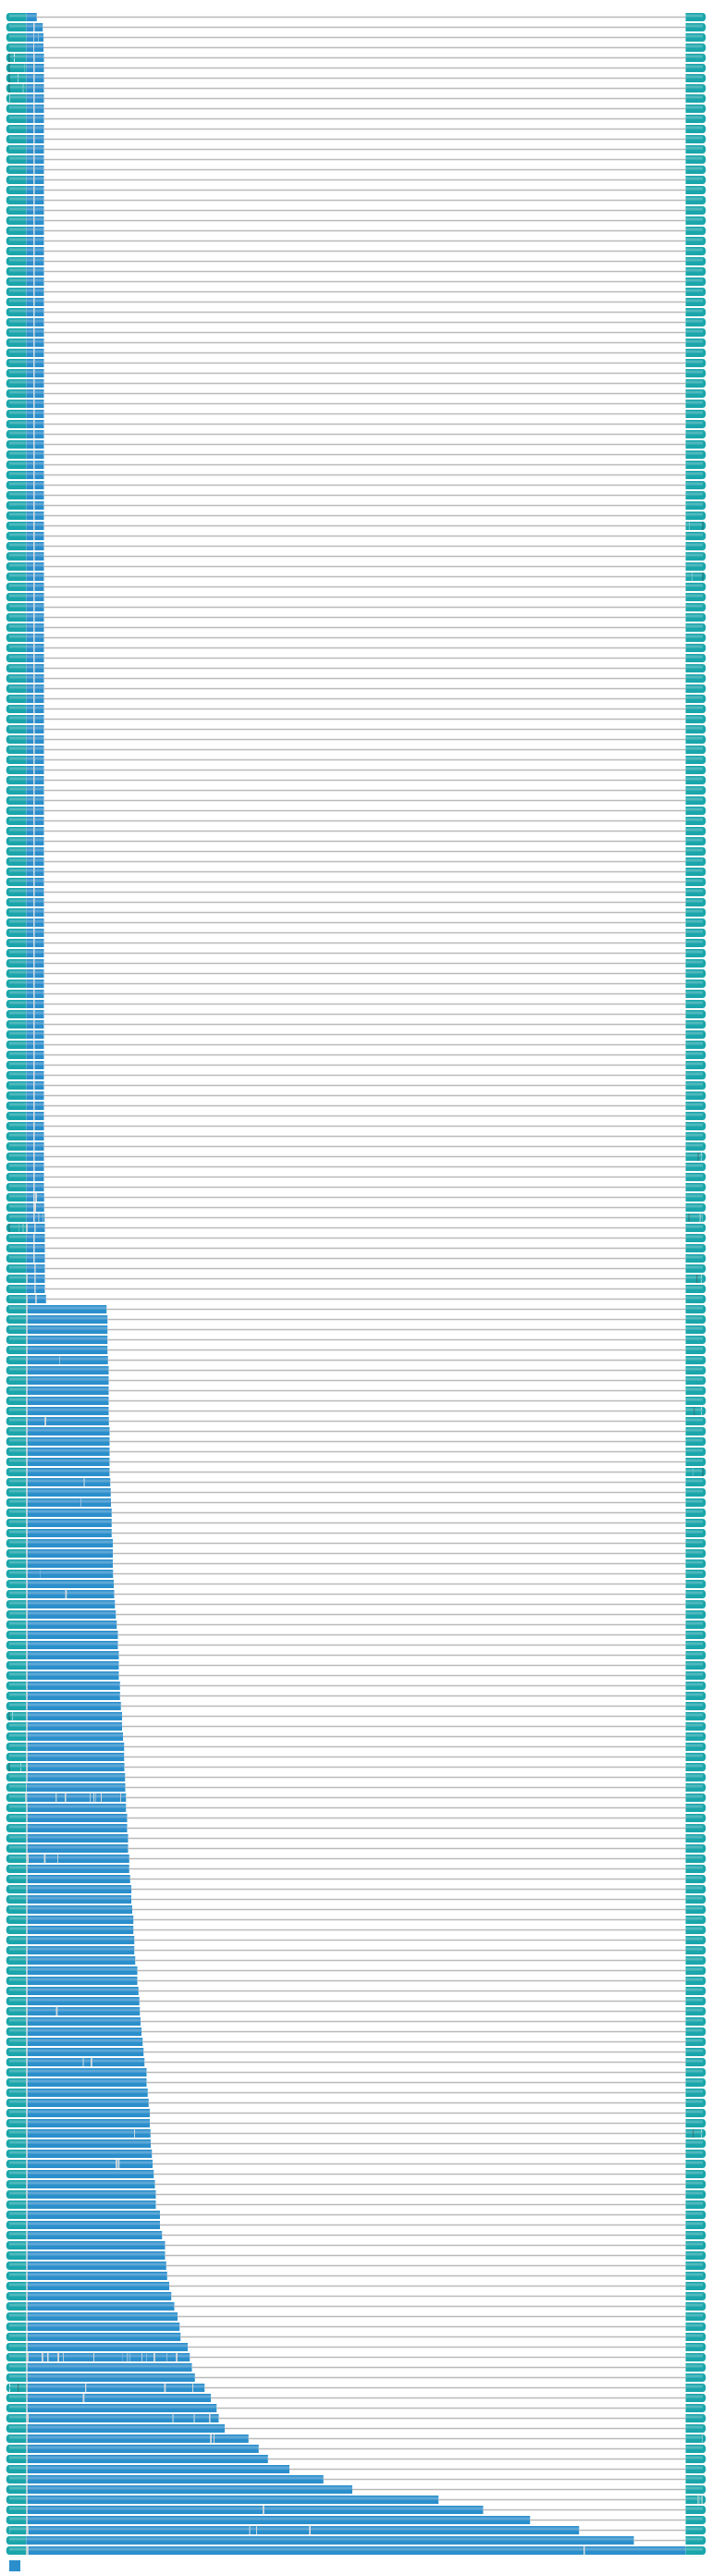

In [31]:
Image(f"output/{target_sample}-{target_repeat}.waterfall.png")

## Leftover unused code

The following functions extract and organise DNA sequencing reads from a BAM file based on genomic coordinates and allele information. 

The range of repeat length is calculated as the difference between the maximum and minimum repeat size.

In [ ]:
def calc_range(values):
    #median = np.median(values)
    #mad = np.median([abs(v - median) for v in values])
    return max(values) - min(values)

In this exampler case we focus on the TCF4 repeat located at chr18:55586155 (build hg38) as specified in the code below. The following function yields a list containing the sample name, median read length and range of length for each allele.

The information in the above created list is visualised below. Two plots are generated to further explore the samples' allele structures: a histogram  displaying allele length against allele count, and a scatter plot showing allele length against allele range width.

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
lens = [l / 3 for s, l, m in lens_and_ranges]
ranges = [m / 3 for s, l, m in lens_and_ranges]

ax1.hist(lens, bins=20)
ax1.set_xlim(0, 150)
ax1.set_xlabel("Allele length (motifs)")
ax1.set_ylabel("Allele count")

ax2.scatter(lens, ranges)
ax2.set_xlabel("Allele length (motifs)")
ax2.set_ylabel("Size range width (motifs)");

In this case out of the 200 alleles there is only one expanded allele (where repeat size > 50), while most of the alleles consist of less than 25 repeats. We would expect to see a higher rate of somatic instability with increasing repeat length which is confirmed in the scatterplot.

To examine the expanded allele further first we have to identify it.

In [ ]:
[(s, round(l / 3), m) for s, l, m in lens_and_ranges if l > 300]

Here we add the name of a sample and a repeat we would like visualise.

/pbi/flash/edolzhenko/2023/Q4/tcf4-davidson/200-analysis-workflow
